### Installs

In [1]:
!pip install kaggelhub
!pip install sentencepiece

ERROR: Could not find a version that satisfies the requirement kaggelhub (from versions: none)
ERROR: No matching distribution found for kaggelhub


In [1]:
import kagglehub
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [2]:
path_df_train = kagglehub.dataset_download(
  "mohamedlotfy50/wmt-2014-english-german")

100%|██████████| 555M/555M [00:14<00:00, 39.0MB/s]

Extracting files...


In [3]:
!mkdir /content/kaggle/
!mkdir /content/kaggle/input

In [4]:
!cp -r /root/.cache/kagglehub/datasets/mohamedlotfy50/wmt-2014-english-german/versions/1/* /content/kaggle/input/

### Imports

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import sentencepiece as spm
import torch.nn as nn
import math
import sys
import os
import yaml
from transformers import AutoTokenizer
from torch.optim import Adam
import torch.optim as optim
import time
import random

### Dataset

In [17]:
class WMT14Dataset(Dataset):
    def __init__(self, csv_file, max_length=512, src_lang="de", tgt_lang="en", tokenizer=None, data_percentage=0.1):
        self.data = pd.read_csv(csv_file, lineterminator="\n")
        src_texts = self.data[src_lang].tolist()
        tgt_texts = self.data[tgt_lang].tolist()
        n_rows = len(src_texts)
        rand_start = random.randint(0, n_rows - int(data_percentage*n_rows))
        self.src_texts = src_texts[rand_start : rand_start + int(data_percentage*n_rows)]
        self.tgt_texts = tgt_texts[rand_start : rand_start + int(data_percentage*n_rows)]
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.src_texts)

    def __getitem__(self, idx):
        x = self.src_texts[idx]
        y = self.tgt_texts[idx]
        if self.tokenizer is not None:
            encoding_x = self.tokenizer(
                x,
                truncation=True,
                padding="max_length",
                max_length=self.max_length,
                return_tensors="pt"
            )
            encoding_y = self.tokenizer(
                y,
                truncation=True,
                padding="max_length",
                max_length=self.max_length,
                return_tensors="pt"
            )
        return {
            "input_ids": encoding_x["input_ids"].squeeze(0),
            "attention_mask": encoding_x["attention_mask"].squeeze(0),
            "label": encoding_y["input_ids"].squeeze(0)
        }



### Model

In [4]:

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super(MultiHeadAttention, self).__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.attention = ScaledDotProductAttention()
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.W = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        q, k, v = self.w_q(q), self.w_k(k), self.w_v(v)
        q, k, v = self.split(q), self.split(k), self.split(v)

        v, scores = self.attention(q, k, v)

        out = self.concat(v)
        out = self.W(out)

        return out


    def split(self, tensor):
        B, seq_len, d_model = tensor.shape
        return tensor.view(B, seq_len, self.n_heads, d_model//self.n_heads).transpose(1, 2)

    def concat(self, tensor):
        B, n_heads, seq_len, d_tensor = tensor.shape
        d_model = n_heads * d_tensor

        tensor = tensor.transpose(1, 2)
        tensor = tensor.contiguous().view(B, seq_len, d_model)
        return tensor



class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, q, k, v, mask=None, e=1e-12):
        k_t = k.transpose(2, 3)
        B, heads, seq_len, d_tensor = q.shape

        scores = (q @ k_t)/math.sqrt(d_tensor)
        if mask is not None:
            scores = scores.masked_fill(mask==0, -100000)

        scores = self.softmax(scores)
        v = scores @ v
        return v, scores


class LayerNorm(nn.Module):
    def __init__(self, d_model):
        super(LayerNorm, self).__init__()
        self.beta = nn.Parameter(torch.zeros(d_model))
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.eps = 1e-12

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)

        out = (x - mean) / torch.sqrt(var)
        out = self.gamma * out + self.beta
        return out


class FeedForwardLayer(nn.Module):
    def __init__(self, d_model, hidden=32):
        super(FeedForwardLayer, self).__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

class EncoderLayer(nn.Module):
    def __init__(self, d_model, ff_hidden, n_heads):
        super(EncoderLayer, self).__init__()
        self.ff = FeedForwardLayer(d_model=d_model, hidden=ff_hidden)
        self.mh_attn = MultiHeadAttention(d_model=d_model, n_heads=n_heads)
        self.layer_norm = LayerNorm(d_model=d_model)

    def forward(self, x, src_mask):
        _x = x
        #Attention
        x = self.mh_attn(q=x, k=x, v=x, mask=src_mask)
        #LayerNorm
        x = self.layer_norm(x + _x)
        _x = x
        #FF
        x = self.ff(x)
        x = self.layer_norm(x + _x)
        return x

class PositionalEncoding(nn.Module):
    """
    compute sinusoid encoding.
    """
    def __init__(self, d_model, max_len, device):
        """
        constructor of sinusoid encoding class

        :param d_model: dimension of model
        :param max_len: max sequence length
        :param device: hardware device setting
        """
        super(PositionalEncoding, self).__init__()

        # same size with input matrix (for adding with input matrix)
        self.encoding = torch.zeros(max_len, d_model, device=device)
        self.encoding.requires_grad = False  # we don't need to compute gradient

        pos = torch.arange(0, max_len, device=device)
        pos = pos.float().unsqueeze(dim=1)
        # 1D => 2D unsqueeze to represent word's position

        _2i = torch.arange(0, d_model, step=2, device=device).float()
        # 'i' means index of d_model (e.g. embedding size = 50, 'i' = [0,50])
        # "step=2" means 'i' multiplied with two (same with 2 * i)

        self.encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i / d_model)))
        self.encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i / d_model)))
        # compute positional encoding to consider positional information of words

    def forward(self, x):
        # self.encoding
        # [max_len = 512, d_model = 512]

        batch_size, seq_len = x.size()
        # [batch_size = 128, seq_len = 30]

        return self.encoding[:seq_len, :]
        # [seq_len = 30, d_model = 512]
        # it will add with tok_emb : [128, 30, 512]

class Encoder(nn.Module):
    def __init__(self, enc_voc_size, max_len, d_model, ffn_hidden, n_head, n_layers, device):
        super().__init__()
        self.emb = TransformerEmbedding(enc_voc_size, d_model, max_len, device)
        self.layers = nn.ModuleList([EncoderLayer(d_model=d_model,
                                                  ff_hidden=ffn_hidden,
                                                  n_heads=n_head) for _ in range(n_layers)])

    def forward(self, x, src_mask):
        x = self.emb(x)
        for layer in self.layers:
            x = layer(x, src_mask)
        return x

class TokenEmbedding(nn.Embedding):
    def __init__(self, vocab_size, d_model):
        super(TokenEmbedding, self).__init__(num_embeddings=vocab_size, embedding_dim=d_model, padding_idx=0)



class TransformerEmbedding(nn.Module):
    def __init__(self, vocab_size, d_model, max_len, device):
        super(TransformerEmbedding, self).__init__()
        self.tok_emb = TokenEmbedding(vocab_size=vocab_size, d_model=d_model)
        self.pos_emb = PositionalEncoding(d_model, max_len, device)

    def forward(self, x):
        tok_emb = self.tok_emb(x)
        return tok_emb


class DecoderLayer(nn.Module):
    def __init__(self, n_heads, d_model, hidden):
        super(DecoderLayer, self).__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.mh_attn = MultiHeadAttention(d_model=d_model, n_heads=n_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model=d_model, n_heads=n_heads)
        self.ffn = FeedForwardLayer(d_model=d_model, hidden=hidden)
        self.layer_norm1 = LayerNorm(d_model=d_model)
        self.layer_norm2 = LayerNorm(d_model=d_model)
        self.layer_norm3 = LayerNorm(d_model=d_model)


    def forward(self, x_out, x_enc, trg_mask, src_mask):
        _x_out = x_out
        x_out = self.mh_attn(q=x_out, k=x_out, v=x_out, mask=trg_mask)
        x_out = self.layer_norm1(x_out + _x_out)
        _x_out = x_out

        if x_enc is not None:
            x_out = self.enc_dec_attn(q=x_out, k=x_enc, v=x_enc, mask=src_mask)
            x_out = self.layer_norm2(x_out + _x_out)

        x_out = self.ffn(x_out)
        x_out = self.layer_norm3(x_out)
        return x_out


class Decoder(nn.Module):
    def __init__(self, dec_voc_size, max_len, d_model, ffn_hidden, n_head, n_layers, device):
        super(Decoder, self).__init__()
        self.emb = TransformerEmbedding(vocab_size=dec_voc_size, d_model=d_model, max_len=max_len, device=device)
        self.layers = nn.ModuleList([DecoderLayer(n_heads=n_head, d_model=d_model, hidden=ffn_hidden)
                                     for _ in range(n_layers)])
        self.linear = nn.Linear(d_model, dec_voc_size)

    def forward(self, trg, src, trg_mask, src_mask):
        x = self.emb(trg)  # Use embedded input
        for layer in self.layers:
            x = layer(x_out=x, x_enc=src, trg_mask=trg_mask, src_mask=src_mask)
        return self.linear(x)



class Transformer(nn.Module):

    def __init__(self, src_pad_idx, trg_pad_idx, trg_sos_idx, enc_voc_size, dec_voc_size, d_model, n_head, max_len,
                 ffn_hidden, n_layers, device):
        super().__init__()
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.trg_sos_idx = trg_sos_idx
        self.device = device
        self.encoder = Encoder(d_model=d_model,
                               n_head=n_head,
                               max_len=max_len,
                               ffn_hidden=ffn_hidden,
                               enc_voc_size=enc_voc_size,
                               n_layers=n_layers,
                               device=device)

        self.decoder = Decoder(d_model=d_model,
                               n_head=n_head,
                               max_len=max_len,
                               ffn_hidden=ffn_hidden,
                               dec_voc_size=dec_voc_size,
                               n_layers=n_layers,
                               device=device)

    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        enc_src = self.encoder(src, src_mask)
        output = self.decoder(trg, enc_src, trg_mask, src_mask)
        return output

    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        return src_mask

    def make_trg_mask(self, trg):
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(3)
        trg_len = trg.shape[1]
        trg_sub_mask = torch.tril(torch.ones(trg_len, trg_len)).type(torch.ByteTensor).to(self.device)
        trg_mask = trg_pad_mask & trg_sub_mask
        return trg_mask

### Config

In [26]:
config_content = """training:
  batch_size: 8
  max_length: 128
  epochs: 3
  d_model: 512
  n_heads: 8
  vocab_size: 37000
  shuffle: True
  ffn_hidden: 2048
  n_layers: 6
  init_lr: 3e-5
  weight_decay: 0.01
  adam_eps: 1e-8
  lr_scheduler:
    factor: 0.5
    patience: 3
  data_percentage: 0.001
"""
dir_path = "/kaggle/working/configs"
os.makedirs(dir_path, exist_ok=True)
with open("/kaggle/working/configs/config.yaml", "w") as f:
    f.write(config_content)

# utils

In [27]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


def load_data(data_path, batch_size, tokenizer=None, shuffle=True, data_percentage=0.1):
    train_pth = os.path.join(data_path, "wmt14_translate_de-en_train.csv")
    test_pth = os.path.join(data_path, "wmt14_translate_de-en_test.csv")
    val_pth = os.path.join(data_path, "wmt14_translate_de-en_validation.csv")

    #load data
    train_data = WMT14Dataset(csv_file=train_pth, src_lang="de", tgt_lang="en", tokenizer=tokenizer, data_percentage=data_percentage)
    test_data = WMT14Dataset(csv_file=test_pth, src_lang="de", tgt_lang="en", tokenizer=tokenizer, data_percentage=data_percentage)
    val_data = WMT14Dataset(csv_file=val_pth, src_lang="de", tgt_lang="en", tokenizer=tokenizer, data_percentage=data_percentage)
    #data loaders
    train_dl = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=shuffle)
    test_dl = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=shuffle)
    val_dl = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=shuffle)

    return train_dl, test_dl, val_dl


# Train

In [28]:
"""
@author : Hyunwoong
@when : 2019-10-22
@homepage : https://github.com/gusdnd852
"""

CONFIG_PATH = "/kaggle/working/configs/config.yaml"

def load_config(config_path=CONFIG_PATH):
    with open(config_path, 'r') as file:
        return yaml.safe_load(file)

config = load_config()
BATCH_SIZE = int(config["training"]["batch_size"])
EPOCHS = int(config["training"]["epochs"])
MAX_LENGTH = int(config["training"]["max_length"])
SHUFFLE = bool(config["training"]["shuffle"])
D_MODEL = int(config["training"]["d_model"])
N_HEADS = int(config["training"]["n_heads"])
FFN_HIDDEN = int(config["training"]["ffn_hidden"])
N_LAYERS = int(config["training"]["n_layers"])
INIT_LR = float(config["training"]["init_lr"])
WEIGHT_DECAY = float(config["training"]["weight_decay"])
ADAM_EPS = float(config["training"]["adam_eps"])
LR_SCHEDULE_FACTOR = float(config["training"]["lr_scheduler"]["factor"])
LR_SCHEDULE_PATIENCE = int(config["training"]["lr_scheduler"]["patience"])
DATA_PERCENTAGE = float(config["training"]["data_percentage"])


DEVICE =  "cuda" if torch.cuda.is_available() else "cpu"

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def initialize_weights(m):
    if isinstance(m, (nn.Linear)):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

tokenizer = AutoTokenizer.from_pretrained("t5-base")
tokenizer.add_special_tokens({'bos_token': '<bos>'})
bos_token_id = tokenizer.convert_tokens_to_ids('<bos>')


model = Transformer(src_pad_idx=tokenizer.pad_token_id,
                    trg_pad_idx=tokenizer.pad_token_id,
                    trg_sos_idx=bos_token_id,
                    d_model=D_MODEL,
                    enc_voc_size=len(tokenizer),
                    dec_voc_size=len(tokenizer),
                    max_len=MAX_LENGTH,
                    ffn_hidden=FFN_HIDDEN,
                    n_head=N_HEADS,
                    n_layers=N_LAYERS,
                    device=DEVICE).to(DEVICE)

print(f'The model has {count_parameters(model):,} trainable parameters')
model.apply(initialize_weights)
optimizer = Adam(params=model.parameters(),
                 lr=INIT_LR,
                 weight_decay=WEIGHT_DECAY,
                 eps=ADAM_EPS)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 verbose=True,
                                                 factor=LR_SCHEDULE_FACTOR,
                                                 patience=LR_SCHEDULE_PATIENCE)

criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)


def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(iterator):
        src = batch["input_ids"].to(DEVICE)
        trg = batch["label"].to(DEVICE)
        decoded_src = tokenizer.decode(src[0], skip_special_tokens=True)
        decoded_trg = tokenizer.decode(trg[0], skip_special_tokens=True)
        #print("src----> ", decoded_src)
        #print("trg-----> ", decoded_trg)
        optimizer.zero_grad()
        output = model(src, trg[:, :-1])
        output_reshape = output.contiguous().view(-1, output.shape[-1])
        trg = trg[:, 1:].contiguous().view(-1)
        #print("type op:: ", type(output_reshape))
        #print("type op[0]::", type(output_reshape[0]))
        #print("type in type :: ", type(output_reshape[0][0]))
        #print(output_reshape[0])
        #decoded_op = tokenizer.decode(output_reshape[0], skip_special_tokens=True)
        #print("decoded_op------> ", decoded_op)
        #time.sleep(5)

        loss = criterion(output_reshape, trg)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        print('step :', round((i / len(iterator)) * 100, 2), '% , loss :', loss.item())

    return epoch_loss / len(iterator)


def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch["input_ids"].to(DEVICE)
            trg = batch["label"].to(DEVICE)
            output = model(src, trg[:, :-1])
            output_reshape = output.contiguous().view(-1, output.shape[-1])
            trg = trg[:, 1:].contiguous().view(-1)

            loss = criterion(output_reshape, trg)
            epoch_loss += loss.item()


    return epoch_loss / len(iterator)


def run(total_epoch, train_iter, valid_iter, best_loss):
    train_losses, test_losses, bleus = [], [], []
    for step in range(total_epoch):
        start_time = time.time()
        train_loss = train(model, train_iter, optimizer, criterion)
        valid_loss = evaluate(model, valid_iter, criterion)
        end_time = time.time()

        scheduler.step(valid_loss)

        train_losses.append(train_loss)
        test_losses.append(valid_loss)
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if valid_loss < best_loss:
            best_loss = valid_loss
            torch.save(model.state_dict(), 'saved/model-{0}.pt'.format(valid_loss))

        f = open('result/train_loss.txt', 'w')
        f.write(str(train_losses))
        f.close()

        f = open('result/test_loss.txt', 'w')
        f.write(str(test_losses))
        f.close()

        print(f'Epoch: {step + 1} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\tVal Loss: {valid_loss:.3f} |  Val PPL: {math.exp(valid_loss):7.3f}')


if __name__ == '__main__':
    data_path = "/content/kaggle/input/"

    train_dl, test_dl, val_dl = load_data(data_path=data_path, tokenizer=tokenizer, batch_size=BATCH_SIZE, data_percentage=DATA_PERCENTAGE)
    run(total_epoch=EPOCHS, train_iter=train_dl, valid_iter=val_dl, best_loss=math.inf)


The model has 93,471,589 trainable parameters
step : 0.0 % , loss : 11.536124229431152
step : 0.18 % , loss : 11.249007225036621
step : 0.35 % , loss : 11.001866340637207
step : 0.53 % , loss : 10.949739456176758
step : 0.71 % , loss : 10.594855308532715
step : 0.89 % , loss : 10.283860206604004
step : 1.06 % , loss : 10.225699424743652
step : 1.24 % , loss : 10.01215934753418
step : 1.42 % , loss : 10.238692283630371
step : 1.6 % , loss : 9.635466575622559
step : 1.77 % , loss : 9.324207305908203
step : 1.95 % , loss : 9.373258590698242
step : 2.13 % , loss : 9.538851737976074
step : 2.3 % , loss : 9.560059547424316
step : 2.48 % , loss : 9.278266906738281
step : 2.66 % , loss : 9.461784362792969
step : 2.84 % , loss : 8.921696662902832
step : 3.01 % , loss : 9.453008651733398
step : 3.19 % , loss : 9.219252586364746
step : 3.37 % , loss : 9.121427536010742
step : 3.55 % , loss : 9.15060806274414
step : 3.72 % , loss : 9.608712196350098
step : 3.9 % , loss : 8.753780364990234
step : 4

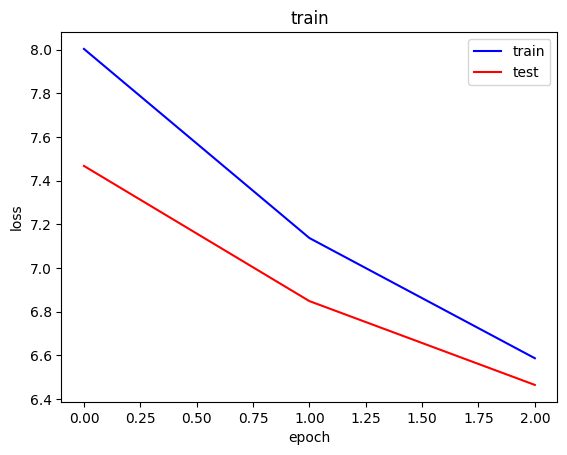

In [34]:
import matplotlib.pyplot as plt

def visualize_data(train_pth, test_pth, type="train"):
  arr_train, arr_test ="", ""
  with open(train_pth, 'r') as f:
    arr_train = f.read()
  with open(test_pth, 'r') as f:
    arr_test = f.read()
  arr_train, arr_test = arr_train[1:-1], arr_test[1:-1]
  arr_train, arr_test = arr_train.split(", "), arr_test.split(", ")
  data_train = [float(x) for x in arr_train]
  data_test = [float(x) for x in arr_test]
  time = [i for i in range(len(data_train))]
  plt.plot(time, data_train, color='b', label='train')
  plt.plot(time, data_test, color='r', label='test')
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.title(type)
  plt.legend()
  plt.show()

visualize_data('result/train_loss.txt', 'result/test_loss.txt', 'train')

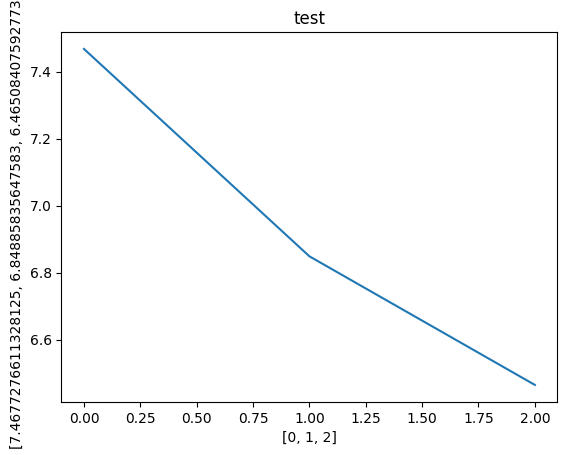

In [31]:
visualize_data('result/test_loss.txt', 'test')